# Naïve Bayes Text Classifier — AG News (Portfolio Version)

**Goal.** Build and evaluate a simple Naïve Bayes text classifier (from scratch) to categorize news into four topics using the AG News dataset.

**Dataset.** [AG News](https://huggingface.co/datasets/ag_news) (English):  
- Classes: `world`, `sports`, `business`, `sci_tech`  
- Sizes: ~120k (train), ~7.6k (test)

**Method.**
1. Load raw texts and labels.
2. Vectorize titles with a bag-of-words model (binary features).
3. Train a custom **NaïveBayesClassifier** (last column in the DataFrame = label).
4. Evaluate with:
   - Accuracy, confusion matrices (counts + normalized, pastel heatmaps).
   - ROC curves (one-vs-rest) + per-class AUC.

**Why Naïve Bayes?**  
Fast, simple, and surprisingly strong for bag-of-words text classification.

**Reproducibility.**  
We fix random seeds, limit vocabulary (`max_features`) for stable results, and avoid data leakage by fitting the vectorizer on the training split only.

> Note: This notebook uses a custom `NaiveBayesClassifier` (the same one used in Part 1), which expects a **dense** DataFrame of features with the **label as the last column**. It also multiplies raw probabilities (no logs), so we keep features binary and vocabulary modest to avoid underflow.


## SetUp

In [ ]:
# Core
import numpy as np
import pandas as pd
import random

# Data + vectorization
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
import feedparser

# Metrics / plots
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Classifier
from naive_bayes_classifier import NaiveBayesClassifier



: 

In [19]:
# Load AG News (train/test provided by the dataset)
ds = load_dataset("ag_news")

# Map numeric labels to names
label_names = np.array(["world", "sports", "business", "sci_tech"])
x_train = ds["train"]["text"]
y_train = label_names[np.array(ds["train"]["label"])]

x_test  = ds["test"]["text"]
y_test  = label_names[np.array(ds["test"]["label"])]

print(f"Train size: {len(x_train)} | Test size: {len(x_test)}")
print("Classes:", np.unique(y_train))


Train size: 120000 | Test size: 7600
Classes: ['business' 'sci_tech' 'sports' 'world']


## Vectorize
fit on train only


In [ ]:
MAX_FEATURES = 3000  # modest for stability and speed

vectorizer = CountVectorizer(
    stop_words="english",
    max_features=MAX_FEATURES,
    binary=True,  # 0/1 features match the custom NB well
)

vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)

print("Vocabulary size:", len(vectorizer.vocabulary_))
print("X_train shape:", X_train.shape, " | X_test shape:", X_test.shape)


Vocabulary size: 3000
X_train shape: (120000, 3000)  | X_test shape: (7600, 3000)


## Adapt input
Convert to the DataFrame format your class expects

In [24]:
def to_nb_df(X_sparse, y, feature_names):
    """
    Convert a sparse matrix + labels into a dense DataFrame
    with the label as the last column (name 'Category').
    """
    arr = X_sparse.toarray().astype("uint8")
    df = pd.DataFrame(arr, columns=feature_names)
    df["Category"] = y
    return df

df_train = to_nb_df(X_train, y_train, vectorizer.get_feature_names_out())
df_test  = to_nb_df(X_test,  y_test,  vectorizer.get_feature_names_out())

df_train.head(2)


,000,04,05,10,100,10th,11,12,13,14,...,yen,yesterday,york,young,yukos,zarqawi,zealand,zimbabwe,zone,Category
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business


## Train 
Train Naïve Bayes

In [26]:
nb = NaiveBayesClassifier()
nb.fit(df_train)
print("Classes learned:", nb.classes)


Classes learned: ['business' 'sci_tech' 'sports' 'world']


## Evaluation

In [34]:
def nb_scores_batch(nb, X_bin_df):
    """
    Vectorized class scores for all samples in X_bin_df (no per-row loops).
    Uses the same probability model as the custom classifier (no logs).
    Returns: (n_samples, n_classes) aligned with nb.classes
    """
    # Extract dense binary matrix (without the label column)
    X_bin = X_bin_df.to_numpy(dtype=np.uint8)
    n_samples, n_features = X_bin.shape
    n_classes = len(nb.classes)

    # Precompute P(x=1|class) and P(x=0|class) for each feature
    p1 = np.zeros((n_classes, n_features), dtype=np.float64)
    p0 = np.zeros((n_classes, n_features), dtype=np.float64)

    for i in range(n_classes):
        for j, col in enumerate(nb.columns[:-1]):
            d = nb.conditional_probs[i][j]  # dict {value: prob}
            p1[i, j] = d.get(1, 0.0)
            p0[i, j] = d.get(0, 0.0)

    scores = np.empty((n_samples, n_classes), dtype=np.float64)
    for i in range(n_classes):
        # p1^X * p0^(1-X) for all samples, product across features, then multiply by the prior
        s = (p1[i] ** X_bin) * (p0[i] ** (1 - X_bin))
        s = s.prod(axis=1) * float(nb.priors[i])
        scores[:, i] = s

    return scores

# Compute scores on the test set
X_test_df_only = df_test.drop(columns=["Category"])
scores = nb_scores_batch(nb, X_test_df_only)

# Convert scores to probabilities (row-wise normalization)
row_sums = scores.sum(axis=1, keepdims=True)
probs = np.divide(scores, row_sums, out=np.zeros_like(scores), where=row_sums != 0)

# Class predictions
pred_idx = np.argmax(probs, axis=1)
preds = np.array(nb.classes)[pred_idx]

# Counts
labels = nb.classes
y_true = df_test["Category"].values


### ROC

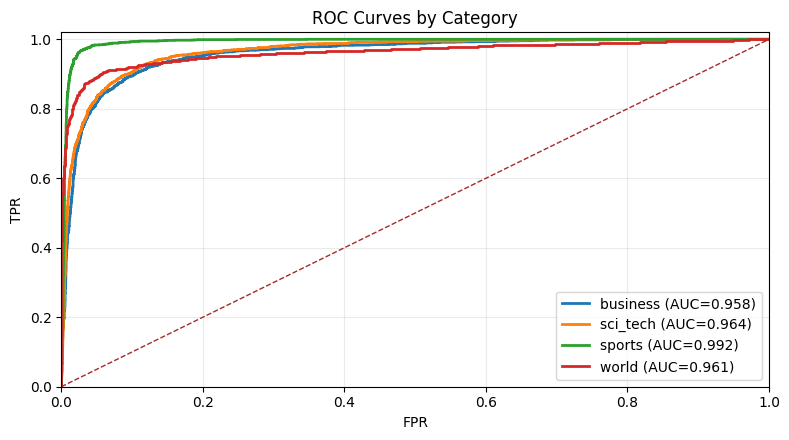

In [36]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(y_true, classes=labels)

plt.figure(figsize=(8, 4.5))
for i, cls in enumerate(labels):
    fpr, tpr, _ = roc_curve(Y[:, i], probs[:, i])
    auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{cls} (AUC={auc_i:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="brown", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves by Category")
plt.legend(loc="lower right")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


### Confusion Matrix

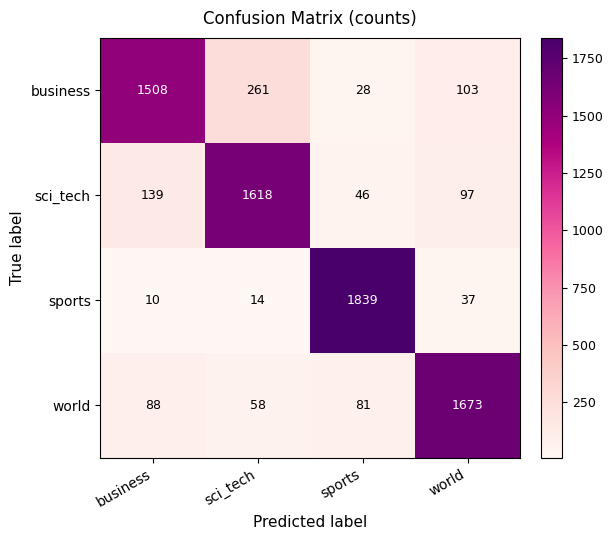

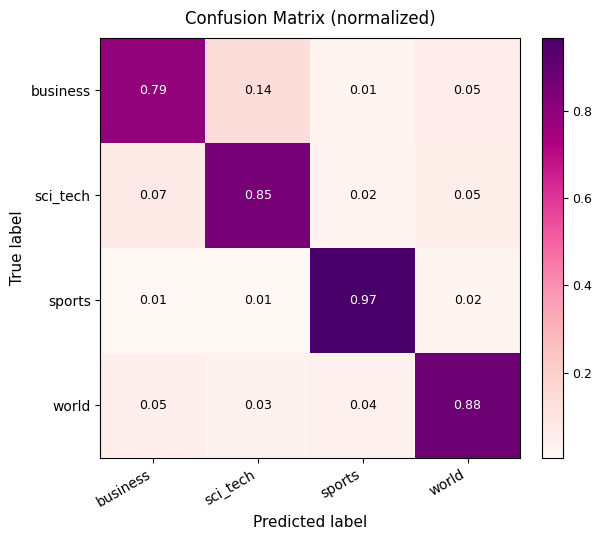

In [37]:
def plot_confusion_heatmap(cm, labels, title, cmap="pink", value_format="d"):
    """Pastel/pink heatmap using pure matplotlib."""
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlabel("Predicted label", fontsize=11)
    ax.set_ylabel("True label", fontsize=11)

    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks, labels, rotation=30, ha="right")
    ax.set_yticks(tick_marks, labels)

    # annotate cells
    thresh = cm.max() / 2.0 if cm.size else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            color = "white" if val > thresh else "black"
            ax.text(j, i, format(val, value_format), ha="center", va="center", color=color, fontsize=9)

    ax.grid(False)
    fig.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, preds, labels=labels)
plot_confusion_heatmap(cm, labels, "Confusion Matrix (counts)", cmap="RdPu", value_format="d")

# Row-normalized
cm_norm = confusion_matrix(y_true, preds, labels=labels, normalize="true")
plot_confusion_heatmap(cm_norm, labels, "Confusion Matrix (normalized)", cmap="RdPu", value_format=".2f")


## Some more tests…

In this section we sanity-check the trained model on **~10 fresh news titles** fetched from Google News RSS (no labels from the training set). We:

- Pull a small sample of titles across several RSS queries (e.g., *politics*, *sports*, *technology*).
- Vectorize them with the **already-fitted** `CountVectorizer` (no refit).
- Predict with our **NaïveBayesClassifier** and print **feed tag vs. model prediction** side-by-side.

**Important notes**

- The model was trained on **four classes only**: `world`, `sports`, `business`, `sci_tech`.  
  RSS tags like `politics`, `health`, etc. are **not** training labels; the model maps them to the **closest** of its four classes.
- RSS “feed category” is **not ground truth** and is used here only for a quick qualitative check. Do **not** use these samples for metrics.
- The vectorizer was fitted on **English AG News**; results are best with English titles.
- Fix a random seed when sampling to make the demo reproducible.


In [ ]:
# Fetch ~10 fresh news titles
CATEGORIES = {
    "politics": "politics",
    "sports": "sports",
    "economy": "economy",
    "technology": "technology",
    "science": "science",
    "entertainment": "entertainment",
    "world": "world news",
}

rows = []
for cat, query in CATEGORIES.items():
    feed_url = (
        f"https://news.google.com/rss/search"
        f"?hl=en&gl=US&ceid=US:en&q={query.replace(' ', '+')}"
    )
    feed = feedparser.parse(feed_url)
    for entry in feed.entries[:6]:  # small per-category; we will sample to 10 total
        rows.append({"title": entry.title, "link": entry.link, "feed_category": cat})

df_news = pd.DataFrame(rows).drop_duplicates(subset=["title"]).reset_index(drop=True)

# Sample exactly 10 (or fewer if not available)
rng = random.Random(123)
take = min(10, len(df_news))
sample_idx = rng.sample(range(len(df_news)), k=take)
df_sample = df_news.iloc[sample_idx].reset_index(drop=True)

# Vectorize with the ALREADY-FITTED vectorizer (do not fit again)
X_news = vectorizer.transform(df_sample["title"])

# Convert to the dense DataFrame shape expected by your NaiveBayesClassifier
df_feats = pd.DataFrame(
    X_news.toarray().astype("uint8"),
    columns=vectorizer.get_feature_names_out()
)

# Predict and print side-by-side (feed category vs model prediction)
print(f"Showing {take} examples (feed_category vs model prediction):\n")
for i in range(take):
    attrs = df_feats.iloc[i].tolist()
    pred, _, posteriors = nb.predict(attrs)
    posteriors = np.asarray(posteriors, dtype=float)
    probs = posteriors / posteriors.sum() if posteriors.sum() > 0 else posteriors

    title = df_sample.loc[i, "title"].strip().replace("\n", " ")
    feed_cat = df_sample.loc[i, "feed_category"]
    print(f"[{i+1}] Feed category: {feed_cat} | Predicted: {pred}")
    print(f"     Title: {title}")
    # print(f"     Probabilities: " + ", ".join(f"{cls}={p:.4f}" for cls, p in zip(nb.classes, probs)))
    print("-" * 80)


Showing 10 examples (feed_category vs model prediction):

[1] Feed category: politics | Predicted: world
     Title: It’s the big fat Greek farming scandal – devised by the political elite and paid for by ordinary people - The Guardian
--------------------------------------------------------------------------------
[2] Feed category: economy | Predicted: business
     Title: CBS News poll finds Americans describe "uncertain" economy as its ratings tick slightly back down - CBS News
--------------------------------------------------------------------------------
[3] Feed category: politics | Predicted: sci_tech
     Title: Is the decline of reading making politics dumber? - economist.com
--------------------------------------------------------------------------------
[4] Feed category: science | Predicted: sci_tech
     Title: Dozens of scientists find errors in a new Energy Department climate report - NPR
--------------------------------------------------------------------------------


Our model was trained on AG News with **four classes only**: `world`, `sports`, `business`, `sci_tech`.  
RSS feed tags like `politics`, `health`, etc. are **out of scope** for the model, so it will map those titles to the **closest** of its four classes. This may look like a mistake, but it’s expected behavior.

**Examples**

- **Feed category:** `politics` → **Predicted:** `sci_tech`  
  *Title:* *Is the decline of reading making politics dumber? — economist.com*

- **Feed category:** `politics` → **Predicted:** `world`  
  *Title:* *Thailand live: Amid political chaos, parliament to vote on third PM in two years — Reuters*

**Takeaway:** When the feed category isn’t one of the training labels, interpret the prediction as the model’s best match among its four classes rather than a direct comparison to the feed tag.
